<a href="https://colab.research.google.com/github/spatank/Curiosity/blob/master/v8/mech_plotting_and_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/Curiosity_v8/')

Mounted at /content/drive


In [ ]:
!ls # run !ls to verify location

build_Wiki_networks.ipynb      persistent_homology_KNOT.ipynb
C_plotting_and_stats.ipynb     persistent_homology_simulations.ipynb
C_plotting.ipynb	       persistent_homology_Wiki.ipynb
Figures			       PH_plotting_and_stats.ipynb
KNOT			       PH_plotting.ipynb
mech_plotting_and_stats.ipynb  Simulations
mech_plotting.ipynb	       Wiki


In [ ]:
import glob
import scipy.io as sio
import numpy as np
from scipy import stats
from scipy import integrate
import random
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [ ]:
import sys
!{sys.executable} -m pip install traces

import traces

def time_normalize_and_merge(timeseries_lst, make_1_1 = False):
    """
    Takes in a list of time series (of possibly different lengths) and
    subsamples them using traces so they all range from 0 and 1 and are defined
    on the same points.
    """
    n_series = len(timeseries_lst)
    timeseries_lst = [traces.TimeSeries(zip(*(np.linspace(0, 1, len(ts)), ts)))
                      for ts in timeseries_lst]
    timeseries_lst = traces.TimeSeries.merge(timeseries_lst)
    if make_1_1:
        timeseries_lst[1.0] = [1.0] * n_series
    X = list(zip(*timeseries_lst.items()))[0]  # x values
    Y = list(zip(*timeseries_lst.items()))[1]  # y values across all series
    return X, Y

def plot_curve(curves_lst, curve_label = 'none', curve_color = 'none', null = 'none'):
  """
  Accepts a list of curves and the identity of the null model used if the data 
  come from one; curve_label and curve_color arguments are used for plotting.
  Plots average curve with a standard deviation/error band. 
  """
  max_nodes = max([len(lst) for lst in curves_lst])
  curves_mat = np.empty([len(curves_lst), max_nodes])
  curves_mat[:] = np.nan
  for i, j in enumerate(curves_lst):
    curves_mat[i][0:len(j)] = j
  numels = np.count_nonzero(~np.isnan(curves_mat), axis = 0)
  mean = np.nanmean(curves_mat, axis = 0)[numels > 1]
  std = np.nanstd(curves_mat, axis = 0)[numels > 1]
  # mins = mean - std
  mins = mean - np.divide(std, np.sqrt(numels[numels > 1]))
  mins = np.maximum(0, mins)
  # maxes = mean + std
  maxes = mean + np.divide(std, np.sqrt(numels[numels > 1]))
  X = np.arange(len(numels[numels > 1]))

  plt.plot(X, mean, color = curve_color, label = curve_label,
            linewidth = 1)
  plt.fill_between(X, mins, maxes, facecolor = curve_color, alpha = 0.2)
  return X, mean

def plot_curve_normalized_idx(curves_lst, curve_label = 'none', curve_color = 'none', null = 'none'):
  """
  Accepts a list of curves and the identity of the null model used if the data 
  come from one; curve_label and curve_color arguments are used for plotting.
  Plots average curve with a standard deviation/error band, and with the x-axis 
  normalized to be [0, 1].
  """
  X, Y = time_normalize_and_merge(curves_lst)
  mean = np.nanmean(Y, axis = 1)
  # mins = np.nanmean(Y, axis = 1) - np.nanstd(Y, axis = 1)
  mins = np.nanmean(Y, axis = 1) - np.nanstd(Y, axis = 1)/np.sqrt(len(curves_lst))
  mins = np.maximum(0, mins)
  # maxes = np.nanmean(Y, axis = 1) + np.nanstd(Y, axis = 1)
  maxes = np.nanmean(Y, axis = 1) + np.nanstd(Y, axis = 1)/np.sqrt(len(curves_lst))

  plt.plot(X, mean, color = curve_color, label = curve_label,
            linewidth = 1)
  plt.fill_between(X, mins, maxes, facecolor = curve_color, alpha = 0.2)
  return X, mean

def permutation_testing(x_1, mean_1, x_2, mean_2):
  y_empirical = mean_1[~np.isnan(mean_1)]
  x_empirical = np.array(x_1)[~np.isnan(mean_1)]
  area_empirical = integrate.trapz(y_empirical, x_empirical) # empirical

  y_null = mean_2[~np.isnan(mean_2)]
  x_null = np.array(x_2)[~np.isnan(mean_2)]
  area_null = integrate.trapz(y_null, x_null) # null

  area_difference = np.abs(area_empirical - area_null)

  empirical_group_size = len(x_empirical)
  null_group_size = len(x_null)

  all_data = list(zip(mean_1, x_1)) + list(zip(mean_2, x_2))

  number_of_permutations = 1000
  counter = 0

  for i in range(number_of_permutations):
    random.shuffle(all_data) # shuffle the data
    new_empirical = sorted(all_data[:empirical_group_size], key = lambda x: x[1])
    new_null = sorted(all_data[empirical_group_size:], key = lambda x: x[1])

    unzip_new_empirical = list(zip(*new_empirical))
    y_empirical_new = unzip_new_empirical[0]
    x_empirical_new = unzip_new_empirical[1]
    area_empirical_new = integrate.trapz(y_empirical_new, x_empirical_new) # empirical new

    unzip_new_null = list(zip(*new_null))
    y_null_new = unzip_new_null[0]
    x_null_new = unzip_new_null[1]
    area_null_new = integrate.trapz(y_null_new, x_null_new) # null new

    area_difference_permuted = np.abs(area_empirical_new - area_null_new)

    if area_difference_permuted > area_difference:
      counter += 1

  p_value = counter/number_of_permutations
  return p_value

  Created wheel for infinity: filename=infinity-1.5-py3-none-any.whl size=3095 sha256=5ee32a796d806bbf9167b6de77d56030bc72b824e91faf30a27b1bd3f29815f2
  Stored in directory: /root/.cache/pip/wheels/ee/2c/f4/26985d995b1d5930ab73914f76ffccd54b1af31c2e68b507bc
Successfully built infinity


# KNOT

In [ ]:
base_path = '/content/drive/My Drive/Curiosity_v8/KNOT/Processed/Mech/'

In [ ]:
files = glob.glob(base_path + '*.mat')

## All Participants

In [ ]:
files = glob.glob(base_path + '*.mat')

all_num_nodes = []
all_d = []
all_d_edge_rewired = []
all_d_latticized = []
all_rigid = []
all_rigid_edge_rewired = []
all_rigid_latticized = []
all_conform = []
all_conform_edge_rewired = []
all_conform_latticized = []
all_DoF = []
all_DoF_edge_rewired = []
all_DoF_latticized = []

for idx, mech_file in enumerate(files):
  data_dict = sio.loadmat(mech_file)
  num_nodes = data_dict['n']
  all_num_nodes.append(num_nodes)

  all_d.append(np.squeeze(data_dict['d']))
  d_edge_rewired = data_dict['d_edge_rewired']
  all_d_edge_rewired.append(list(np.nanmean(d_edge_rewired, axis = 0)))
  d_latticized = data_dict['d_latticized']
  all_d_latticized.append(list(np.nanmean(d_latticized, axis = 0)))

  all_rigid.append(np.squeeze(data_dict['rigid']))
  rigid_edge_rewired = data_dict['rigid_edge_rewired']
  all_rigid_edge_rewired.append(list(np.nanmean(rigid_edge_rewired, axis = 0)))
  rigid_latticized = data_dict['rigid_latticized']
  all_rigid_latticized.append(list(np.nanmean(rigid_latticized, axis = 0)))

  all_conform.append(np.squeeze(data_dict['conform']))
  conform_edge_rewired = data_dict['conform_edge_rewired']
  all_conform_edge_rewired.append(list(np.nanmean(conform_edge_rewired, axis = 0)))
  conform_latticized = data_dict['conform_latticized']
  all_conform_latticized.append(list(np.nanmean(conform_latticized, axis = 0)))

  all_DoF.append(np.squeeze(data_dict['DoF']))
  DoF_edge_rewired = data_dict['DoF_edge_rewired']
  all_DoF_edge_rewired.append(list(np.nanmean(DoF_edge_rewired, axis = 0)))
  DoF_latticized = data_dict['DoF_latticized']
  all_DoF_latticized.append(list(np.nanmean(DoF_latticized, axis = 0)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


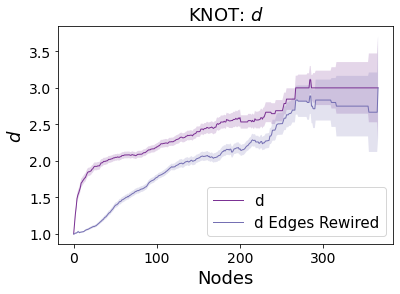

In [ ]:
x_1, mean_1 = plot_curve(all_d, curve_label = 'd', curve_color = '#7b3294')
x_2, mean_2 = plot_curve(all_d_edge_rewired, curve_label = 'd Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_d_latticized, curve_label = 'd Latticized', curve_color = '#d95f02')
plt.title('KNOT: $d$', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('$d$', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/Mech/all_KNOT_d.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.31607629427792916 1.3310263688348183e-16


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


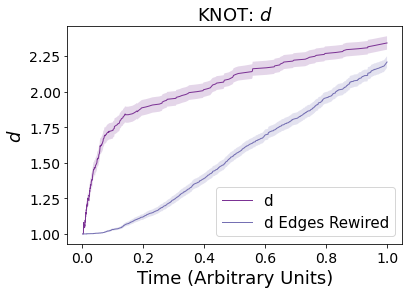

In [ ]:
x_1, mean_1 = plot_curve_normalized_idx(all_d, curve_label = 'd', curve_color = '#7b3294')
x_2, mean_2 = plot_curve_normalized_idx(all_d_edge_rewired, curve_label = 'd Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_d_latticized, curve_label = 'd Latticized', curve_color = '#d95f02')
plt.title('KNOT: $d$', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('$d$', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/Mech/all_KNOT_d_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.13214863706166652 2.629924406649664e-05


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


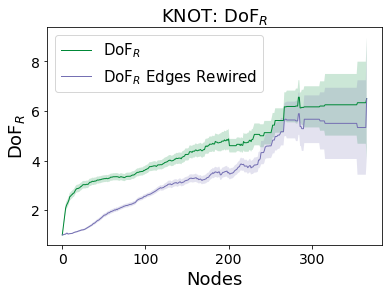

In [ ]:
x_1, mean_1 = plot_curve(all_rigid, curve_label = 'DoF$_R$', curve_color = '#008837')
x_2, mean_2 = plot_curve(all_rigid_edge_rewired, curve_label = 'DoF$_R$ Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_rigid_latticized, curve_label = 'DoF$_R$ Latticized', curve_color = '#d95f02')
plt.title('KNOT: DoF$_R$', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_R$', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/all_KNOT_rigid.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.3188010899182561 6.902636747469822e-17


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


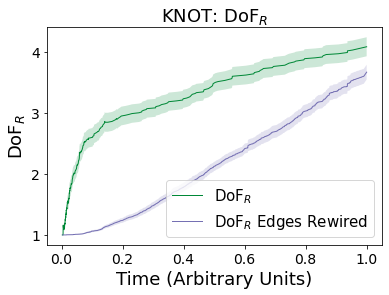

In [ ]:
x_1, mean_1 = plot_curve_normalized_idx(all_rigid, curve_label = 'DoF$_R$', curve_color = '#008837')
x_2, mean_2 = plot_curve_normalized_idx(all_rigid_edge_rewired, curve_label = 'DoF$_R$ Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_rigid_latticized, curve_label = 'DoF$_R$ Latticized', curve_color = '#d95f02')
plt.title('KNOT: DoF$_R$', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('DoF$_R$', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/Mech/all_KNOT_rigid_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.13214863706166652 2.629924406649664e-05


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


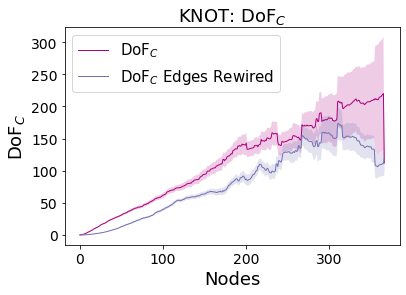

In [ ]:
x_1, mean_1 = plot_curve(all_conform, curve_label = 'DoF$_C$', curve_color = '#ae017e')
x_2, mean_2 = plot_curve(all_conform_edge_rewired, curve_label = 'DoF$_C$ Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_conform_latticized, curve_label = 'DoF$_C$ Latticized', curve_color = '#d95f02')
plt.title('KNOT: DoF$_C$', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_C$', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/all_KNOT_conform.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.25340599455040874 9.291005206839827e-11


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


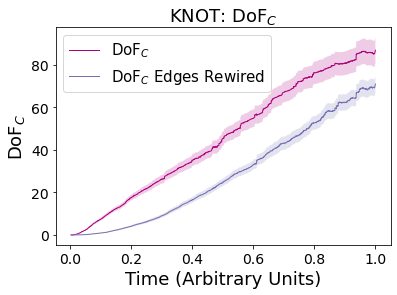

In [ ]:
x_1, mean_1 = plot_curve_normalized_idx(all_conform, curve_label = 'DoF$_C$', curve_color = '#ae017e')
x_2, mean_2 = plot_curve_normalized_idx(all_conform_edge_rewired, curve_label = 'DoF$_C$ Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_conform_latticized, curve_label = 'DoF$_C$ Latticized', curve_color = '#d95f02')
plt.title('KNOT: DoF$_C$', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('DoF$_C$', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/all_KNOT_conform_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.2851576560571365 0.0


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


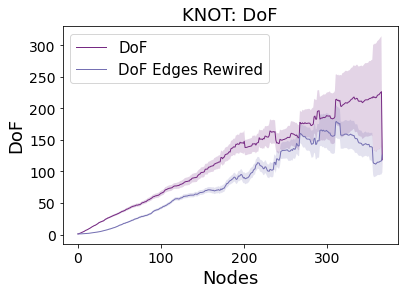

In [ ]:
x_1, mean_1 = plot_curve(all_DoF, curve_label = 'DoF', curve_color = '#762a83')
x_2, mean_2 = plot_curve(all_DoF_edge_rewired, curve_label = 'DoF Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_DoF_latticized, curve_label = 'DoF Latticized', curve_color = '#d95f02')
plt.title('KNOT: DoF', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/all_KNOT_DoF.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.25340599455040874 9.291005206839827e-11


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


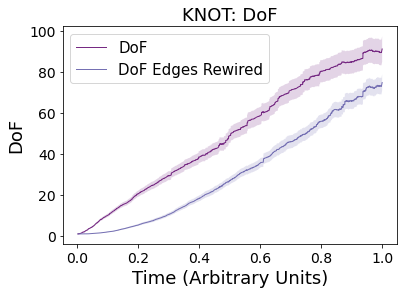

In [ ]:
x_1, mean_1 = plot_curve_normalized_idx(all_DoF, curve_label = 'DoF', curve_color = '#762a83')
x_2, mean_2 = plot_curve_normalized_idx(all_DoF_edge_rewired, curve_label = 'DoF Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_DoF_latticized, curve_label = 'DoF Latticized', curve_color = '#d95f02')
plt.title('KNOT: DoF', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('DoF', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/all_KNOT_DoF_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.2879409168732958 0.0


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


## One Participant

In [ ]:
subj_ID = 106
data_dict = sio.loadmat(base_path + 'subj_' + str(subj_ID) + '_mech.mat')

num_nodes = data_dict['n']

d = np.squeeze(data_dict['d'])
d_edge_rewired = data_dict['d_edge_rewired']
d_latticized = data_dict['d_latticized']

rigid = np.squeeze(data_dict['rigid'])
rigid_edge_rewired = data_dict['rigid_edge_rewired']
rigid_latticized = data_dict['rigid_latticized']

conform = np.squeeze(data_dict['conform'])
conform_edge_rewired = data_dict['conform_edge_rewired']
conform_latticized = data_dict['conform_latticized']

DoF = np.squeeze(data_dict['DoF'])
DoF_edge_rewired = data_dict['DoF_edge_rewired']
DoF_latticized = data_dict['DoF_latticized']

X = np.arange(num_nodes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


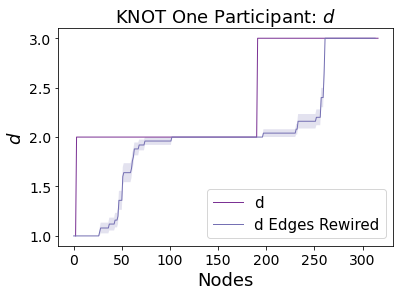

In [ ]:
plt.plot(X, d, color = '#7b3294', label = 'd', linewidth = 1)
x_1, mean_1 = plot_curve(d_edge_rewired, curve_label = 'd Edges Rewired', curve_color = '#7570b3')
# plot_curve(d_latticized, curve_label = 'd Latticized', curve_color = '#d95f02')
plt.title('KNOT One Participant: $d$', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('$d$', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/Mech/one_KNOT_d.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(d, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.3216861901987181 7.438494264988549e-15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


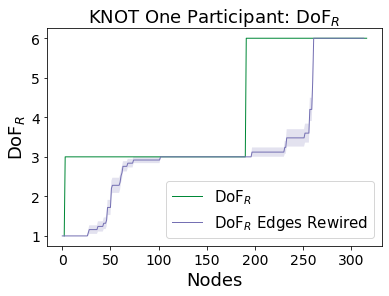

In [ ]:
plt.plot(X, rigid, color = '#008837', label = 'DoF$_R$', linewidth = 1)
x_1, mean_1 = plot_curve(rigid_edge_rewired, curve_label = 'DoF$_R$ Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(rigid_latticized, curve_label = 'DoF$_R$ Latticized', curve_color = '#d95f02')
plt.title('KNOT One Participant: DoF$_R$', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_R$', fontsize = 18)
plt.legend(loc = 'lower right', fontsize = 15)

In [ ]:
ks, p_ks = stats.ks_2samp(rigid, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.3216861901987181 7.438494264988549e-15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


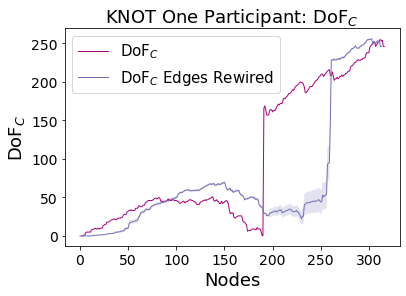

In [ ]:
plt.plot(X, conform, color = '#ae017e', label = 'DoF$_C$', linewidth = 1)
x_1, mean_1 = plot_curve(conform_edge_rewired, curve_label = 'DoF$_C$ Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(conform_latticized, curve_label = 'DoF$_C$ Latticized', curve_color = '#d95f02')
plt.title('KNOT One Participant: DoF$_C$', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_C$', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/one_KNOT_conform.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(conform, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.23499568004179308 3.899693923337111e-08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


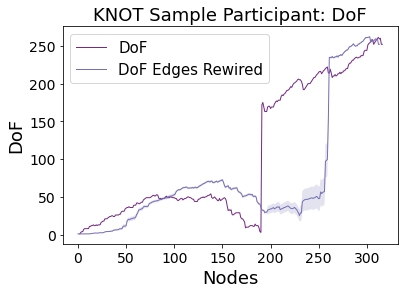

In [ ]:
plt.plot(X, DoF, color = '#762a83', label = 'DoF', linewidth = 1)
x_1, mean_1 = plot_curve(DoF_edge_rewired, curve_label = 'DoF Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(DoF_latticized, curve_label = 'DoF Latticized', curve_color = '#d95f02')
plt.title('KNOT Sample Participant: DoF', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF', fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 15)

In [ ]:
ks, p_ks = stats.ks_2samp(DoF, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.23499568004179308 3.899693923337111e-08


# Wikipedia Networks

In [ ]:
base_path = '/content/drive/My Drive/Curiosity_v8/Wiki/Processed/Mech/'

In [ ]:
files = glob.glob(base_path + '*.mat')

## All Topics

In [ ]:
all_num_nodes = []
all_d = []
all_d_edge_rewired = []
all_d_latticized = []
all_rigid = []
all_rigid_edge_rewired = []
all_rigid_latticized = []
all_conform = []
all_conform_edge_rewired = []
all_conform_latticized = []
all_DoF = []
all_DoF_edge_rewired = []
all_DoF_latticized = []

for idx, mech_file in enumerate(files):
  data_dict = sio.loadmat(mech_file)
  num_nodes = data_dict['n']
  all_num_nodes.append(num_nodes)

  all_d.append(np.squeeze(data_dict['d']))
  d_edge_rewired = data_dict['d_edge_rewired']
  all_d_edge_rewired.append(list(np.nanmean(d_edge_rewired, axis = 0)))
  d_latticized = data_dict['d_latticized']
  all_d_latticized.append(list(np.nanmean(d_latticized, axis = 0)))

  all_rigid.append(np.squeeze(data_dict['rigid']))
  rigid_edge_rewired = data_dict['rigid_edge_rewired']
  all_rigid_edge_rewired.append(list(np.nanmean(rigid_edge_rewired, axis = 0)))
  rigid_latticized = data_dict['rigid_latticized']
  all_rigid_latticized.append(list(np.nanmean(rigid_latticized, axis = 0)))

  all_conform.append(np.squeeze(data_dict['conform']))
  conform_edge_rewired = data_dict['conform_edge_rewired']
  all_conform_edge_rewired.append(list(np.nanmean(conform_edge_rewired, axis = 0)))
  conform_latticized = data_dict['conform_latticized']
  all_conform_latticized.append(list(np.nanmean(conform_latticized, axis = 0)))

  all_DoF.append(np.squeeze(data_dict['DoF']))
  DoF_edge_rewired = data_dict['DoF_edge_rewired']
  all_DoF_edge_rewired.append(list(np.nanmean(DoF_edge_rewired, axis = 0)))
  DoF_latticized = data_dict['DoF_latticized']
  all_DoF_latticized.append(list(np.nanmean(DoF_latticized, axis = 0)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


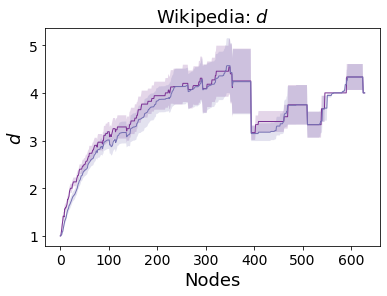

In [ ]:
x_1, mean_1 = plot_curve(all_d, curve_label = 'd', curve_color = '#7b3294')
x_2, mean_2 = plot_curve(all_d_edge_rewired, curve_label = 'd Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_d_latticized, curve_label = 'd Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: $d$', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('$d$', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/Mech/all_Wiki_d.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.12400635930047695 0.00012383653335031064


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


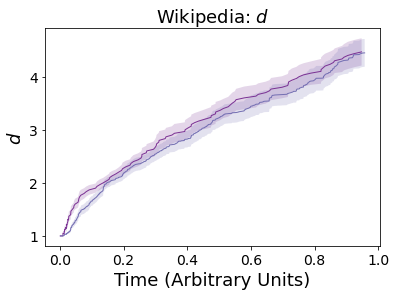

In [ ]:
x_1, mean_1 = plot_curve_normalized_idx(all_d, curve_label = 'd', curve_color = '#7b3294')
x_2, mean_2 = plot_curve_normalized_idx(all_d_edge_rewired, curve_label = 'd Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_d_latticized, curve_label = 'd Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: $d$', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('$d$', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/Mech/all_Wiki_d_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.22072982101707755 3.960384390433447e-06


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


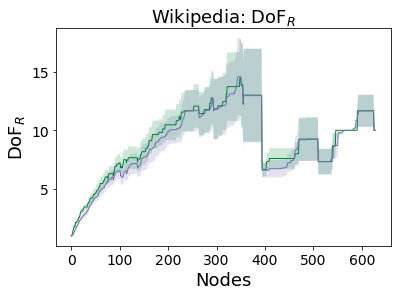

In [ ]:
x_1, mean_1 = plot_curve(all_rigid, curve_label = 'DoF$_R$', curve_color = '#008837')
x_2, mean_2 = plot_curve(all_rigid_edge_rewired, curve_label = 'DoF$_R$ Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_rigid_latticized, curve_label = 'DoF$_R$ Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: DoF$_R$', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_R$', fontsize = 18)
# plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/all_Wiki_rigid.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.1383147853736089 1.1545079721306278e-05


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


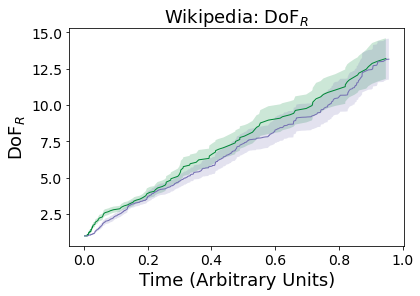

In [ ]:
x_1, mean_1 = plot_curve_normalized_idx(all_rigid, curve_label = 'DoF$_R$', curve_color = '#008837')
x_2, mean_2 = plot_curve_normalized_idx(all_rigid_edge_rewired, curve_label = 'DoF$_R$ Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_rigid_latticized, curve_label = 'DoF$_R$ Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: DoF$_R$', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('DoF$_R$', fontsize = 18)
# plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/all_Wiki_rigid_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.22072982101707755 3.960384390433447e-06


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


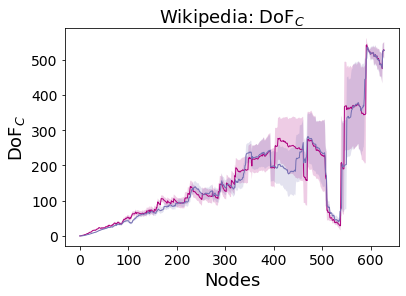

In [ ]:
x_1, mean_1 = plot_curve(all_conform, curve_label = 'DoF$_C$', curve_color = '#ae017e')
x_2, mean_2 = plot_curve(all_conform_edge_rewired, curve_label = 'DoF$_C$ Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_conform_latticized, curve_label = 'DoF$_C$ Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: DoF$_C$', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_C$', fontsize = 18)
# plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/all_Wiki_conform.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.09062003179650238 0.011388320165256847


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


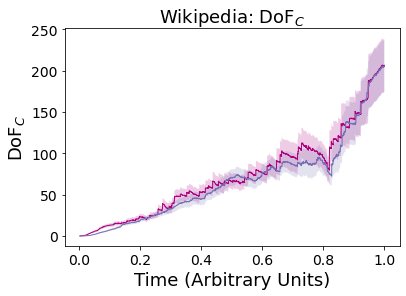

In [ ]:
x_1, mean_1 = plot_curve_normalized_idx(all_conform, curve_label = 'DoF$_C$', curve_color = '#ae017e')
x_2, mean_2 = plot_curve_normalized_idx(all_conform_edge_rewired, curve_label = 'DoF$_C$ Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_conform_latticized, curve_label = 'DoF$_C$ Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: DoF$_C$', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('DoF$_C$', fontsize = 18)
# plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/all_Wiki_conform_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.19130257540754342 1.0


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


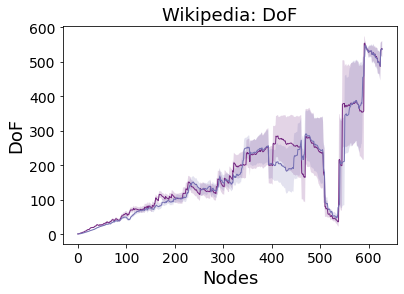

In [ ]:
x_1, mean_1 = plot_curve(all_DoF, curve_label = 'DoF', curve_color = '#762a83')
x_2, mean_2 = plot_curve(all_DoF_edge_rewired, curve_label = 'DoF Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve(all_DoF_latticized, curve_label = 'DoF Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: DoF', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF', fontsize = 18)
# plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/all_Wiki_DoF.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.08426073131955485 0.022950585867320704


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice


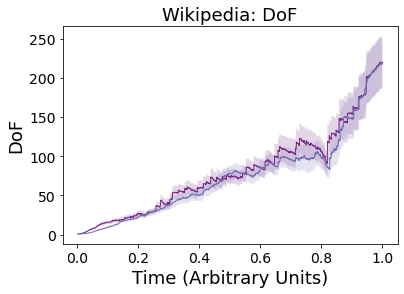

In [ ]:
x_1, mean_1 = plot_curve_normalized_idx(all_DoF, curve_label = 'DoF', curve_color = '#762a83')
x_2, mean_2 = plot_curve_normalized_idx(all_DoF_edge_rewired, curve_label = 'DoF Edges Rewired', curve_color = '#7570b3')
# x_2, mean_2 = plot_curve_normalized_idx(all_DoF_latticized, curve_label = 'DoF Latticized', curve_color = '#d95f02')
plt.title('Wikipedia: DoF', fontsize = 18)
plt.xlabel('Time (Arbitrary Units)', fontsize = 18)
plt.ylabel('DoF', fontsize = 18)
# plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/all_Wiki_DoF_norm_idx.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(mean_1, mean_2, alternative = 'two-sided')
print(ks, p_ks)

0.18855047506778086 1.0


In [ ]:
p_value = permutation_testing(x_1, mean_1, x_2, mean_2)
print(p_value)

0.0


## One Topic

In [ ]:
topic_ID = 'software_engineering'

data_dict = sio.loadmat(base_path + topic_ID + '_mech.mat')

num_nodes = data_dict['n']

d = np.squeeze(data_dict['d'])
d_edge_rewired = data_dict['d_edge_rewired']
d_latticized = data_dict['d_latticized']

rigid = np.squeeze(data_dict['rigid'])
rigid_edge_rewired = data_dict['rigid_edge_rewired']
rigid_latticized = data_dict['rigid_latticized']

conform = np.squeeze(data_dict['conform'])
conform_edge_rewired = data_dict['conform_edge_rewired']
conform_latticized = data_dict['conform_latticized']

DoF = np.squeeze(data_dict['DoF'])
DoF_edge_rewired = data_dict['DoF_edge_rewired']
DoF_latticized = data_dict['DoF_latticized']

X = np.arange(num_nodes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


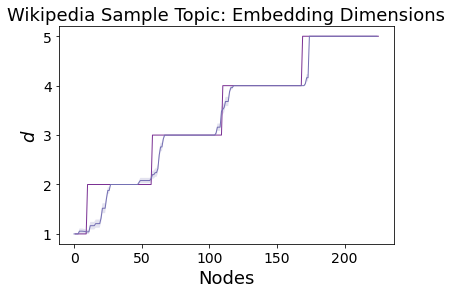

In [ ]:
plt.plot(X, d, color = '#7b3294', label = 'd', linewidth = 1)
x_1, mean_1 = plot_curve(d_edge_rewired, curve_label = 'd Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(d_latticized, curve_label = 'd Latticized', curve_color = '#d95f02')
plt.title('Wikipedia Sample Topic: Embedding Dimensions', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('$d$', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)
plt.savefig('Figures/Mech/one_Wiki_d.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(d, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.08017699115044248 0.43488830708897097


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0, 0.5, 'DoF$_R$')

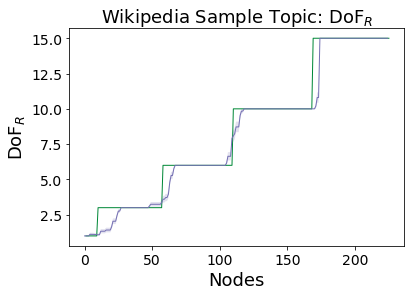

In [ ]:
plt.plot(X, rigid, color = '#008837', label = 'DoF$_R$', linewidth = 1)
x_1, mean_1 = plot_curve(rigid_edge_rewired, curve_label = 'DoF$_R$ Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(rigid_latticized, curve_label = 'DoF$_R$ Latticized', curve_color = '#d95f02')
plt.title('Wikipedia Sample Topic: DoF$_R$', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_R$', fontsize = 18)
# plt.legend(loc = 'lower right', fontsize = 15)

In [ ]:
ks, p_ks = stats.ks_2samp(rigid, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.08017699115044248 0.43488830708897097


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


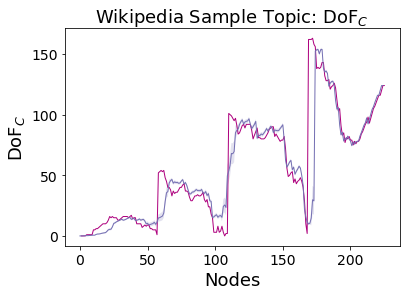

In [ ]:
plt.plot(X, conform, color = '#ae017e', label = 'DoF$_C$', linewidth = 1)
x_1, mean_1 = plot_curve(conform_edge_rewired, curve_label = 'DoF$_C$ Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(conform_latticized, curve_label = 'DoF$_C$ Latticized', curve_color = '#d95f02')
plt.title('Wikipedia Sample Topic: DoF$_C$', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_C$', fontsize = 18)
# plt.legend(loc = 'upper left', fontsize = 15)
plt.savefig('Figures/Mech/one_Wiki_conform.pdf', transparent = True, bbox_inches = 'tight')

In [ ]:
ks, p_ks = stats.ks_2samp(conform, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.07461160275319567 0.5133257993702067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Text(0, 0.5, 'DoF')

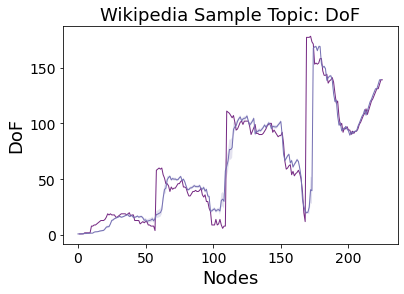

In [ ]:
plt.plot(X, DoF, color = '#762a83', label = 'DoF', linewidth = 1)
x_1, mean_1 = plot_curve(DoF_edge_rewired, curve_label = 'DoF Edges Rewired', curve_color = '#7570b3')
# x_1, mean_1 = plot_curve(DoF_latticized, curve_label = 'DoF Latticized', curve_color = '#d95f02')
plt.title('Wikipedia Sample Topic: DoF', fontsize = 18)
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF', fontsize = 18)
# plt.legend(loc = 'upper left', fontsize = 15)

In [ ]:
ks, p_ks = stats.ks_2samp(DoF, mean_1, alternative = 'two-sided')
print(ks, p_ks)

0.07467059980334316 0.5122104675644534


# Simulated Networks

In [ ]:
data_path = '/content/drive/My Drive/Curiosity_v8/Simulations/simulated_nets_mech.mat'
data_dict = sio.loadmat(data_path)

## Constant Probability Model

In [ ]:
d_CP = data_dict['d_CP']
rigid_CP = data_dict['rigid_CP']
conform_CP = data_dict['conform_CP']
DoF_CP = data_dict['DoF_CP']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


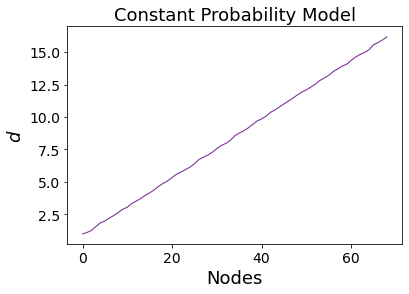

In [ ]:
plot_curve(d_CP, curve_label = 'd', curve_color = '#7b3294')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('$d$', fontsize = 18)
plt.title('Constant Probability Model', fontsize = 18)
plt.savefig('Figures/Mech/constant_probability_d.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


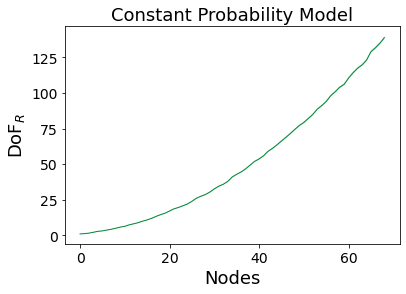

In [ ]:
plot_curve(rigid_CP, curve_label = 'DoF$_R$', curve_color = '#008837')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_R$', fontsize = 18)
plt.title('Constant Probability Model', fontsize = 18)
plt.savefig('Figures/Mech/constant_probability_rigid.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


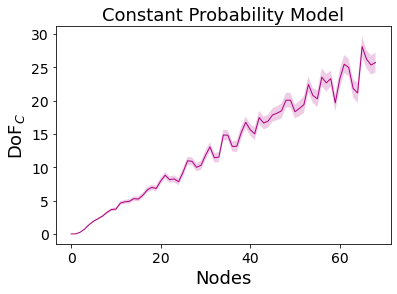

In [ ]:
plot_curve(conform_CP, curve_label = 'DoF$_C$', curve_color = '#ae017e')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_C$', fontsize = 18)
plt.title('Constant Probability Model', fontsize = 18)
plt.savefig('Figures/Mech/constant_probability_conform.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


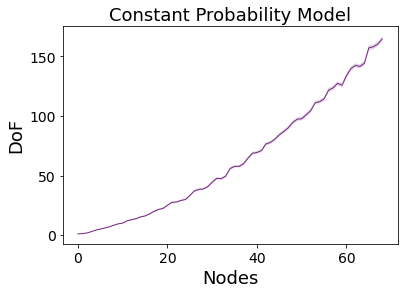

In [ ]:
plot_curve(DoF_CP, curve_label = 'DoF', curve_color = '#762a83')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF', fontsize = 18)
plt.title('Constant Probability Model', fontsize = 18)
plt.savefig('Figures/Mech/constant_probability_DoF.pdf', transparent = True, bbox_inches = 'tight')

## Proportional Probability Model

In [ ]:
d_PP = data_dict['d_PP']
rigid_PP = data_dict['rigid_PP']
conform_PP = data_dict['conform_PP']
DoF_PP = data_dict['DoF_PP']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


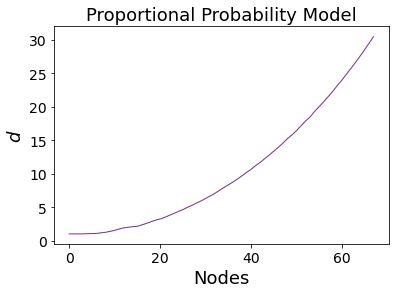

In [ ]:
plot_curve(d_PP, curve_label = 'd', curve_color = '#7b3294')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('$d$', fontsize = 18)
plt.title('Proportional Probability Model', fontsize = 18)
plt.savefig('Figures/Mech/proportional_probability_d.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


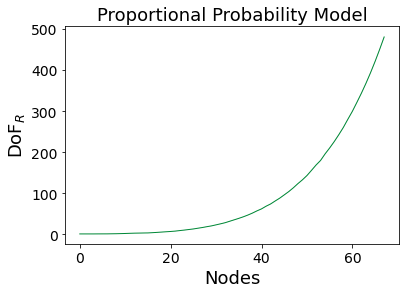

In [ ]:
plot_curve(rigid_PP, curve_label = 'DoF$_R$', curve_color = '#008837')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_R$', fontsize = 18)
plt.title('Proportional Probability Model', fontsize = 18)
plt.savefig('Figures/Mech/proportional_probability_rigid.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


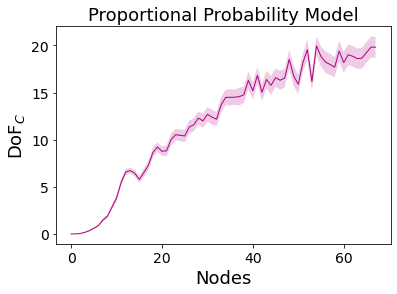

In [ ]:
plot_curve(conform_PP, curve_label = 'DoF$_C$', curve_color = '#ae017e')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_C$', fontsize = 18)
plt.title('Proportional Probability Model', fontsize = 18)
plt.savefig('Figures/Mech/proportional_probability_conform.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


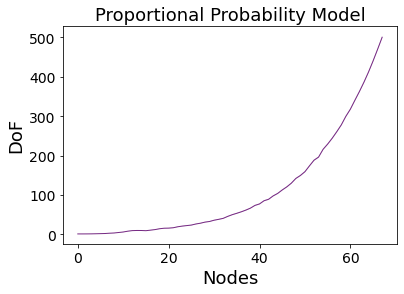

In [ ]:
plot_curve(DoF_PP, curve_label = 'DoF', curve_color = '#762a83')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF', fontsize = 18)
plt.title('Proportional Probability Model', fontsize = 18)
plt.savefig('Figures/Mech/proportional_probability_DoF.pdf', transparent = True, bbox_inches = 'tight')

## Preferential Attachment Model

In [ ]:
d_PA = data_dict['d_PA']
rigid_PA = data_dict['rigid_PA']
conform_PA = data_dict['conform_PA']
DoF_PA = data_dict['DoF_PA']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


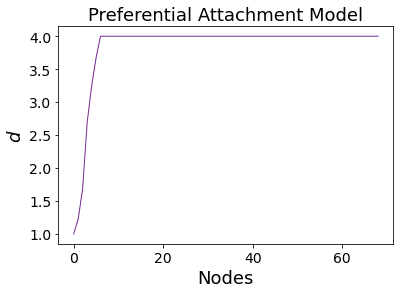

In [ ]:
plot_curve(d_PA, curve_label = 'd', curve_color = '#7b3294')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('$d$', fontsize = 18)
plt.title('Preferential Attachment Model', fontsize = 18)
plt.savefig('Figures/Mech/preferential_attachment_d.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


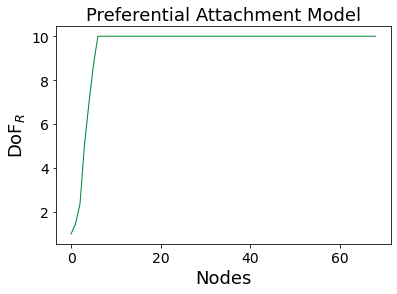

In [ ]:
plot_curve(rigid_PA, curve_label = 'DoF$_R$', curve_color = '#008837')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_R$', fontsize = 18)
plt.title('Preferential Attachment Model', fontsize = 18)
plt.savefig('Figures/Mech/preferential_attachment_rigid.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


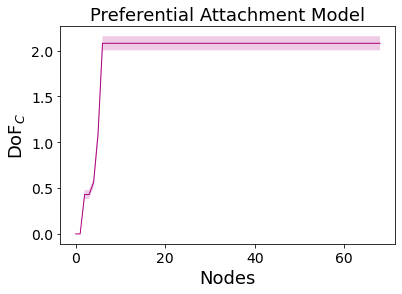

In [ ]:
plot_curve(conform_PA, curve_label = 'DoF$_C$', curve_color = '#ae017e')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF$_C$', fontsize = 18)
plt.title('Preferential Attachment Model', fontsize = 18)
plt.savefig('Figures/Mech/preferential_attachment_conform.pdf', transparent = True, bbox_inches = 'tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


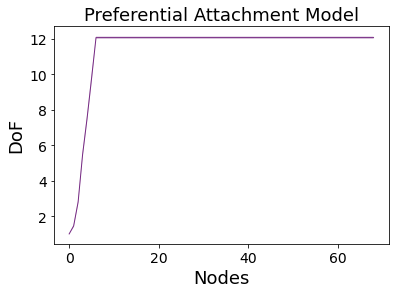

In [ ]:
plot_curve(DoF_PA, curve_label = 'DoF', curve_color = '#762a83')
plt.xlabel('Nodes', fontsize = 18)
plt.ylabel('DoF', fontsize = 18)
plt.title('Preferential Attachment Model', fontsize = 18)
plt.savefig('Figures/Mech/preferential_attachment_DoF.pdf', transparent = True, bbox_inches = 'tight')